In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()

In [3]:
from datasetsforecast.hierarchical import HierarchicalData
from hierarchicalforecast.utils import aggregate, HierarchicalPlot

from neuralforecast.utils import augment_calendar_df

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpnz7pho0_
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpnz7pho0_/_remote_module_non_scriptable.py


In [28]:
Y_df, S_df, tags = HierarchicalData.load('./data', 'TourismLarge')

In [31]:
pd.unique(Y_df['unique_id'])

array(['TotalAll', 'AAll', 'BAll', 'CAll', 'DAll', 'EAll', 'FAll', 'GAll',
       'AAAll', 'ABAll', 'ACAll', 'ADAll', 'AEAll', 'AFAll', 'BAAll',
       'BBAll', 'BCAll', 'BDAll', 'BEAll', 'CAAll', 'CBAll', 'CCAll',
       'CDAll', 'DAAll', 'DBAll', 'DCAll', 'DDAll', 'EAAll', 'EBAll',
       'ECAll', 'FAAll', 'FBAll', 'FCAll', 'GAAll', 'GBAll', 'AAAAll',
       'AABAll', 'ABAAll', 'ABBAll', 'ACAAll', 'ADAAll', 'ADBAll',
       'ADCAll', 'ADDAll', 'AEAAll', 'AEBAll', 'AECAll', 'AEDAll',
       'AFAAll', 'BAAAll', 'BABAll', 'BACAll', 'BBAAll', 'BCAAll',
       'BCBAll', 'BCCAll', 'BDAAll', 'BDBAll', 'BDCAll', 'BDDAll',
       'BDEAll', 'BDFAll', 'BEAAll', 'BEBAll', 'BECAll', 'BEDAll',
       'BEEAll', 'BEFAll', 'BEGAll', 'BEHAll', 'CAAAll', 'CABAll',
       'CACAll', 'CBAAll', 'CBBAll', 'CBCAll', 'CBDAll', 'CCAAll',
       'CCBAll', 'CCCAll', 'CDAAll', 'CDBAll', 'DAAAll', 'DABAll',
       'DACAll', 'DBAAll', 'DBBAll', 'DBCAll', 'DCAAll', 'DCBAll',
       'DCCAll', 'DCDAll', 'DDAAll', 'DDB

In [32]:
S_df.index

Index(['TotalAll', 'AAll', 'BAll', 'CAll', 'DAll', 'EAll', 'FAll', 'GAll',
       'AAAll', 'ABAll',
       ...
       'GBBBus', 'GBBOth', 'GBCHol', 'GBCVis', 'GBCBus', 'GBCOth', 'GBDHol',
       'GBDVis', 'GBDBus', 'GBDOth'],
      dtype='object', length=555)

In [25]:
def sort_df_hier(Y_df, S):
    # NeuralForecast core, sorts unique_id lexicographically
    # by default, this method matches S_df and Y_hat_df hierarchical order.
    Y_df.unique_id = Y_df.unique_id.astype('category')
    Y_df.unique_id = Y_df.unique_id.cat.set_categories(S.index)
    Y_df = Y_df.sort_values(by=['unique_id', 'ds'])
    return Y_df

# Load hierarchical dataset
Y_df, S_df, tags = HierarchicalData.load('./data', 'TourismLarge')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df = sort_df_hier(Y_df, S_df)

Y_df, _ = augment_calendar_df(df=Y_df, freq='M')

In [26]:
Y_df

,unique_id,ds,y,month
0,TotalAll,1998-01-01,45151.071280,-0.500000
1,TotalAll,1998-02-01,17294.699551,-0.409091
2,TotalAll,1998-03-01,20725.114184,-0.318182
3,TotalAll,1998-04-01,25388.612353,-0.227273
4,TotalAll,1998-05-01,20330.035211,-0.136364
...,...,...,...,...
126535,GBDOth,2016-08-01,0.000000,0.136364
126536,GBDOth,2016-09-01,0.000000,0.227273
126537,GBDOth,2016-10-01,0.000000,0.318182
126538,GBDOth,2016-11-01,0.000000,0.409091


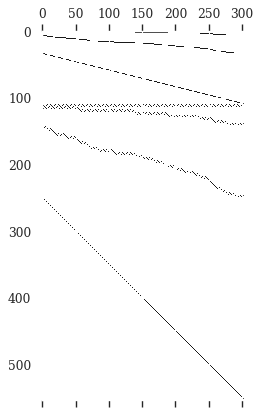

In [5]:
# Here we plot the hierarchical constraints matrix
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()


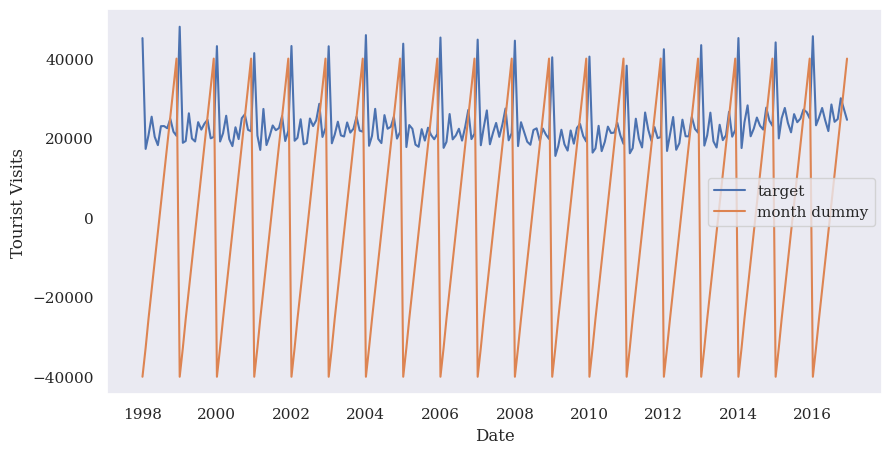

In [6]:
# Here we plot the top most series from the dataset
# that corresponds to the total tourist monthly visits to Australia
plt.figure(figsize=(10,5))
plt.plot(Y_df[Y_df['unique_id']=='TotalAll']['ds'], 
         Y_df[Y_df['unique_id']=='TotalAll']['y'], label='target')
plt.plot(Y_df[Y_df['unique_id']=='TotalAll']['ds'], 
         Y_df[Y_df['unique_id']=='TotalAll']['month']*80000, label='month dummy')
plt.xlabel('Date')
plt.ylabel('Tourist Visits')
plt.legend()
plt.grid()
plt.show()
plt.close()


In [7]:
import numpy as np

from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx, NHITS, HINT
from neuralforecast.losses.pytorch import GMM, PMM, DistributionLoss, sCRPS


In [8]:
# Train test splits
horizon = 12
Y_test_df  = Y_df.groupby('unique_id').tail(horizon)
Y_train_df = Y_df.drop(Y_test_df.index)
Y_test_df  = Y_test_df.set_index('unique_id')
Y_train_df = Y_train_df.set_index('unique_id')


In [9]:
# Horizon and quantiles
level = np.arange(0, 100, 2)
qs = [[50-lv/2, 50+lv/2] if lv!=0 else [50] for lv in level]
quantiles = np.sort(np.concatenate(qs)/100)

# HINT := BaseNetwork + Distribution + Reconciliation
nhits = NHITS(h=horizon,
              input_size=24,
              loss=GMM(n_components=10, quantiles=quantiles),
              hist_exog_list=['month'],
              max_steps=2000,
              early_stop_patience_steps=10,
              val_check_steps=50,
              scaler_type='robust',
              learning_rate=1e-3,
              valid_loss=sCRPS(quantiles=quantiles))

model = HINT(h=horizon, S=S_df.values,
             model=nhits,  reconciliation='BottomUp')


INFO:lightning_fabric.utilities.seed:Global seed set to 1


In [10]:
Y_df['y'] = Y_df['y'] * (Y_df['y'] > 0)
nf = NeuralForecast(models=[model], freq='MS')
# Y_hat_df = nf.cross_validation(df=Y_df, val_size=12, n_windows=1)
nf.fit(df=Y_train_df, val_size=12)
Y_hat_df = nf.predict()


2023-12-03 17:49:25.966133: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 17:49:27.380811: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Predicting DataLoader 0: 100%|██████████| 18/18 [00:00<00:00, 88.39it/s]


[]

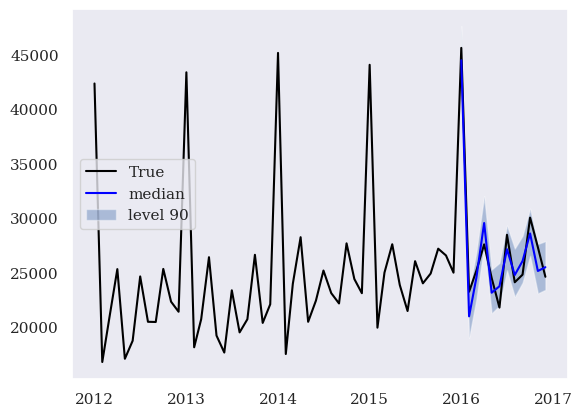

In [11]:
unique_id = 'TotalAll'
Y_plot_df = Y_df[Y_df.unique_id==unique_id].tail(12*5)
Y_hat_df = Y_hat_df.reset_index()
plot_df = Y_hat_df[Y_hat_df.unique_id==unique_id]
plot_df = Y_plot_df.merge(plot_df, on=['unique_id', 'ds'], how='left')

plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['HINT-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:],
                 y1=plot_df['HINT-lo-90.0'][-12:].values,
                 y2=plot_df['HINT-hi-90.0'][-12:].values,
                 alpha=0.4, label='level 90')
plt.legend()
plt.grid()
plt.plot()
